In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
ds, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

In [3]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1 #so the mask contain 3 dim diffcolors  --> zero base index
  return input_image, input_mask

def load_train_image(datapoint):
  # data augmentation
  input_image  = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  
  #data augmentation
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  # normalize the image and mask
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask

def load_test_image(datapoint):
  # data augmentation
  input_image  = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  
  # normalize the image and mask
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask




In [4]:
train_dataset = ds['train'].map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = ds['test'].map(load_test_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [5]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

#### Explainatory Data Analysis

In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)
    plt.axis('off')
  plt.show()



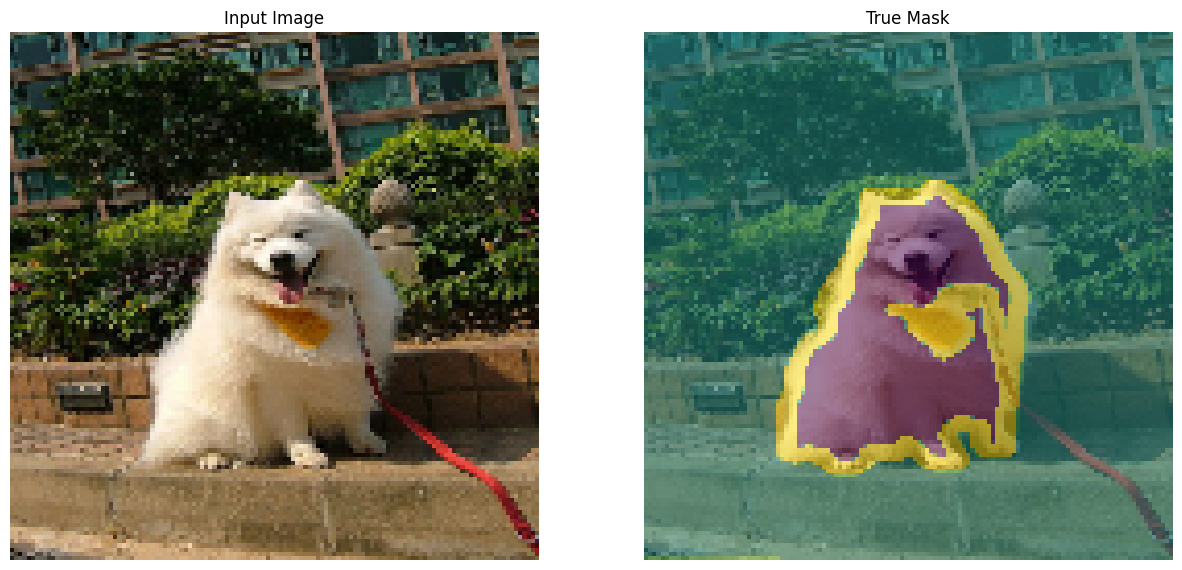

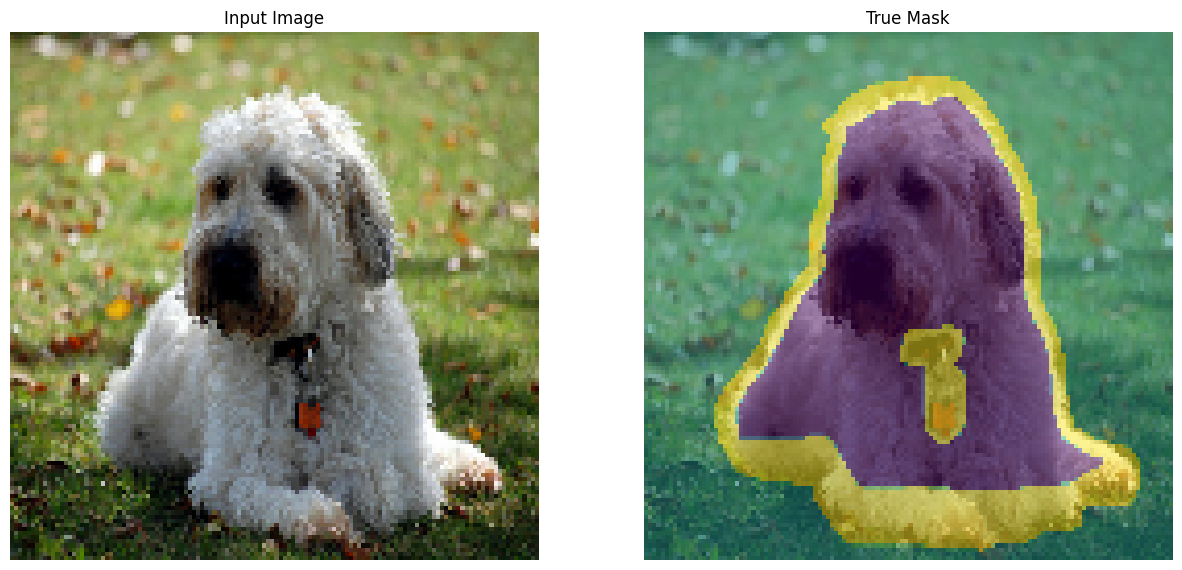

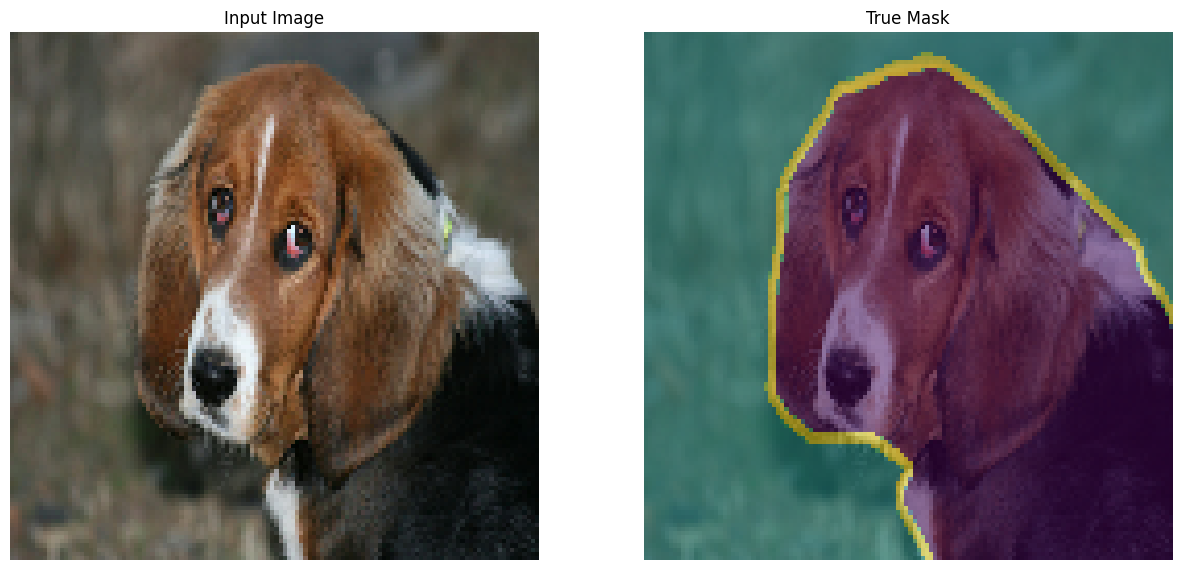

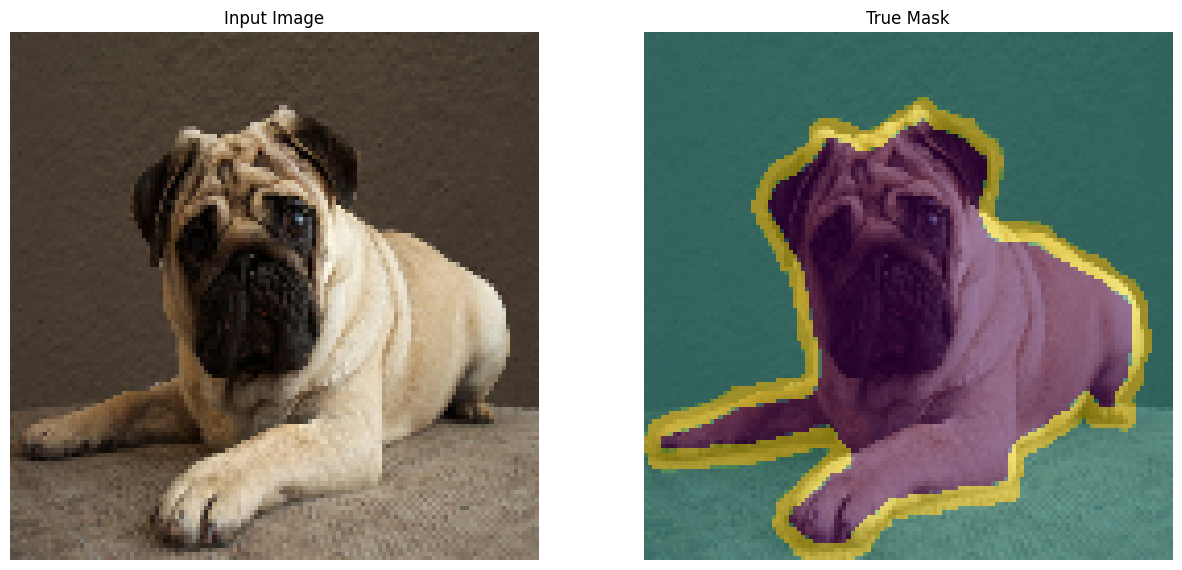

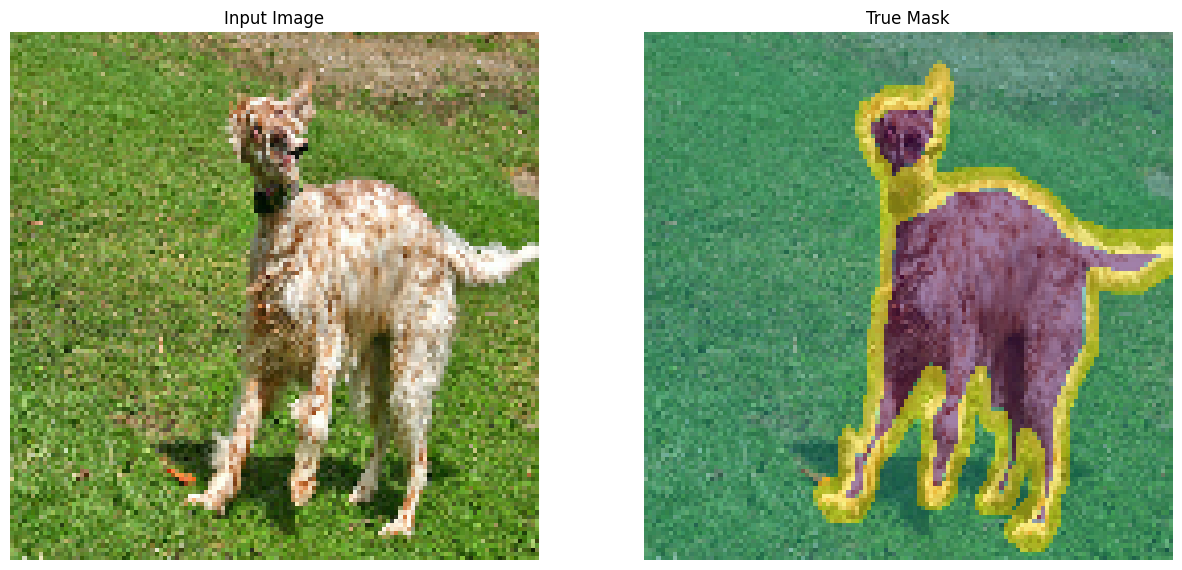

In [7]:
for images, masks in train_dataset.take(5):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

#### define unet model

In [8]:
def double_conv_block(x, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = tf.keras.layers.concatenate([x, conv_features])
    x = tf.keras.layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [14]:
def build_unet(input_shape = (128, 128, 3) ,output_channels = 3):
    inputs = tf.keras.layers.Input(input_shape)
    
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    # f4, p4 = downsample_block(p3, 512)
    
    #intermediate layer
    intermediate_layer = double_conv_block(p3, 512)

    # upsample decoding
    # u1 = upsample_block(intermediate_layer, f4, 512)
    u2 = upsample_block(intermediate_layer, f3, 256)
    u3 = upsample_block(u2, f2, 128)
    u4 = upsample_block(u3, f1, 64)

    outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation='softmax')(u4)
    model = tf.keras.models.Model(inputs, outputs , name = 'U-Net')
    return model


In [20]:
import tensorflow as tf

def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters, (3,3), padding="same", activation="relu")(x)
    return x

def downsample_block(x, filters):
    f = conv_block(x, filters)
    p = tf.keras.layers.MaxPooling2D((2,2))(f)
    return f, p

def upsample_block(x, f, filters):
    x = tf.keras.layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding="same")(x)
    x = tf.keras.layers.Concatenate()([x, f])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(128, 128, 3), output_channels=3):
    inputs = tf.keras.layers.Input(input_shape)

    f1, p1 = downsample_block(inputs, 32)
    f2, p2 = downsample_block(p1, 64)
    f3, p3 = downsample_block(p2, 128)

    # Intermediate layer
    intermediate_layer = conv_block(p3, 256)

    # Upsampling
    u2 = upsample_block(intermediate_layer, f3, 128)
    u3 = upsample_block(u2, f2, 64)
    u4 = upsample_block(u3, f1, 32)

    outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation='softmax')(u4)
    model = tf.keras.models.Model(inputs, outputs, name='U-Net-Lite')

    return model


In [21]:
model = build_unet()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [22]:
model.summary()

Model: "U-Net-Lite"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_34[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_36[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ conv2d_37[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_38[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 16, 16,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_40[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 32, 32,    │    131,200 │ conv2d_41[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    295,040 │ concatenate_7[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_42[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 64, 64,    │     32,832 │ conv2d_43[0][0] 

 Total params: 1,925,667 (7.35 MB)

 Trainable params: 1,925,667 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
     create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


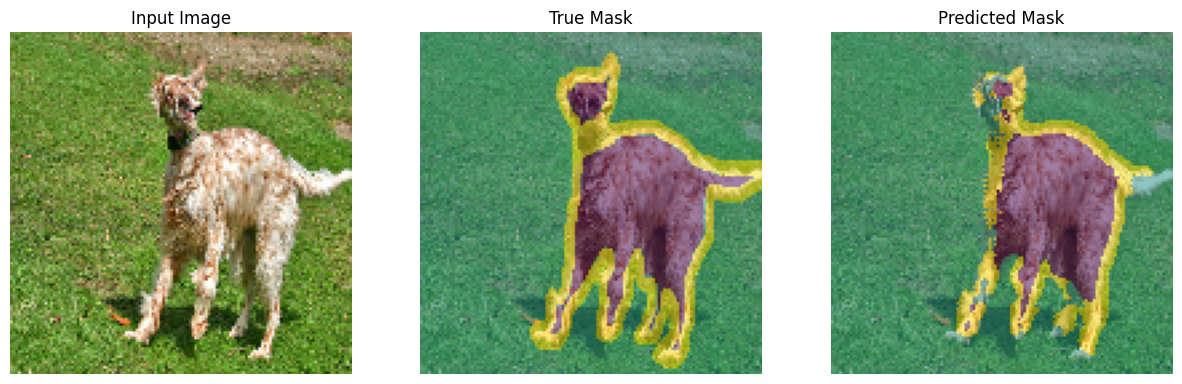


Sample Prediction after epoch 3

230/230 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7307 - loss: 0.6372 - val_accuracy: 0.7678 - val_loss: 0.5645


In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

    
EPOCHS = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS
STEPS_PER_EPOCH = info.splits['train'].num_examples // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

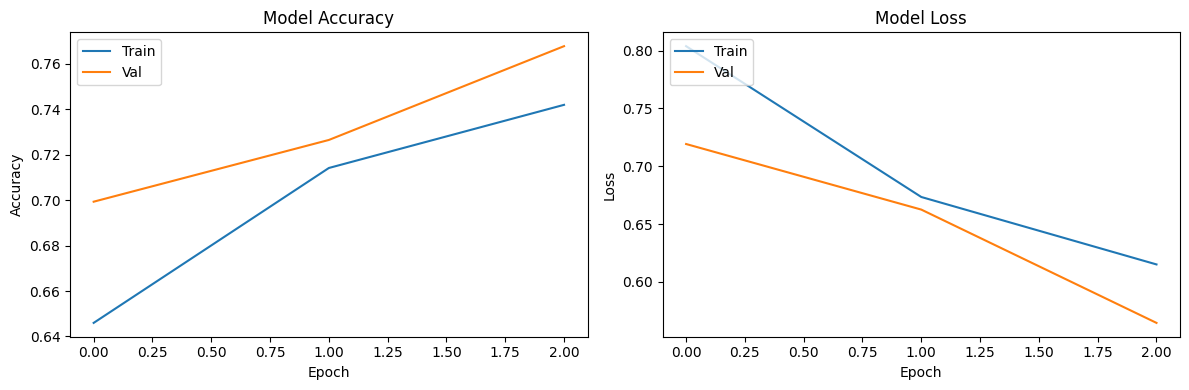

In [25]:
history = model_history
# plot train & val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


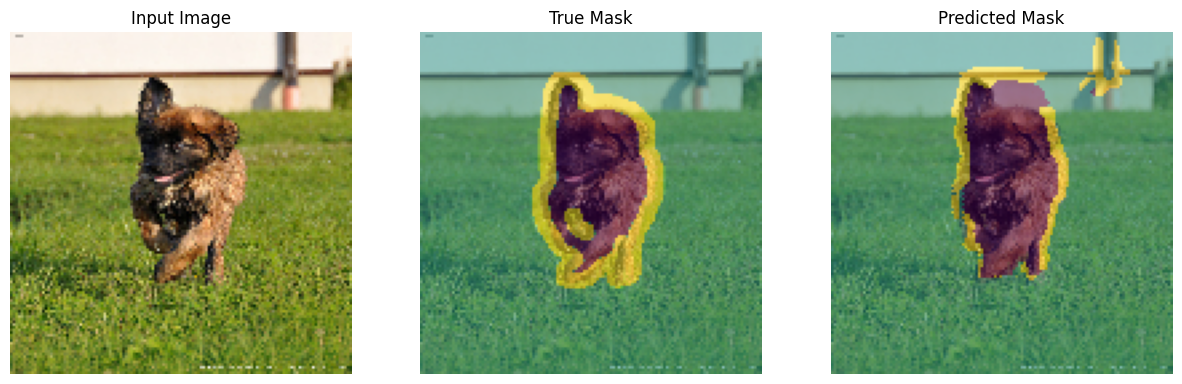

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


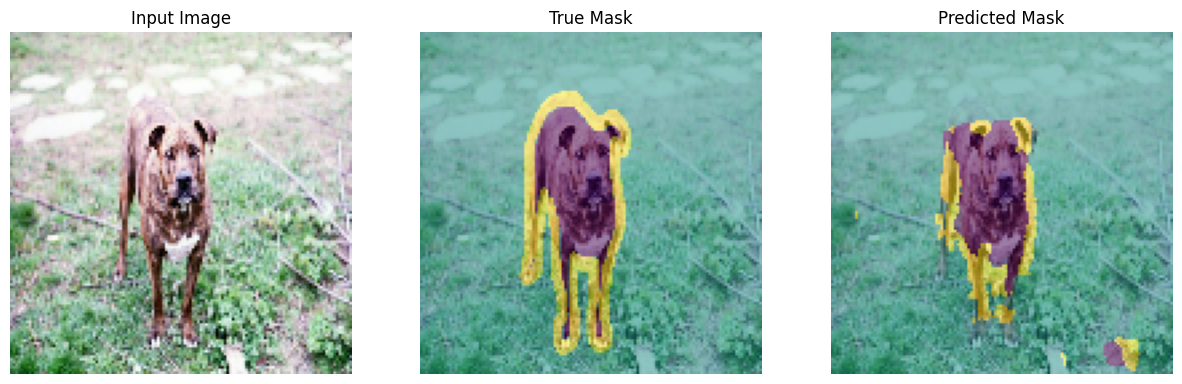

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


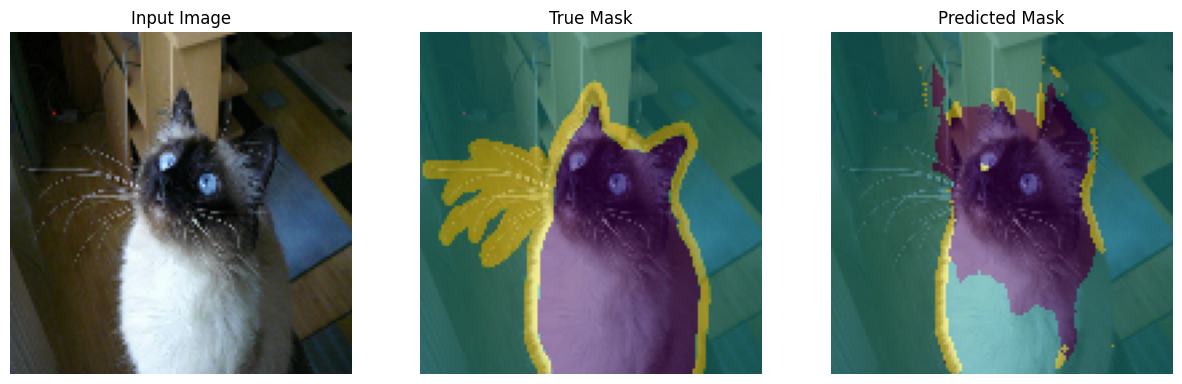

In [26]:
show_predictions(test_dataset, 3)